# Evaluation Notebook

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import os
import pickle

from typing import Union, Literal, Dict, Optional, Tuple

from eval import read_run_dir, get_err_from_run, compute_scaling_err, get_timed_err_from_run
from plot_utils import plot_model_errs

%matplotlib inline
%load_ext autoreload
%autoreload 2


sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
3,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
4,pretrained_relu,decision_tree,Transformer-ReLU,depth=4,-1,-1,20,12,8,decision_tree_standard
5,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
6,pretrained_relu,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard
2,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
0,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained
1,pretrained_relu,sparse_linear_regression,Transformer-ReLU,sparsity=3,-1,-1,20,12,8,sparse_regression_standard


In [3]:
task: Union[
    Literal["linear_regression"], 
    Literal["sparse_linear_regression"], 
    Literal["decision_tree"], 
    Literal["relu_2nn_regression"]
] = "linear_regression"

models = df[df.task == task].reset_index(drop=True)
models["run_path"] = models.apply(lambda row: os.path.join(run_dir, row['task'], row['run_id']), axis=1)
models

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,run_path
0,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained,../models/linear_regression/pretrained
1,pretrained_relu,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard,../models/linear_regression/pretrained_relu


## Plot Generation

We will now directly load the model and measure its in-context learning ability on a larger batch of random inputs. (We expand the batch size to obtain better estimates)

### Setup

In [4]:
bs_x = lambda factor: (lambda bs: bs * factor)
bs = lambda batch_size: (lambda _: batch_size)
scale = lambda factor: (lambda x: x * factor)

optimals = {
    "linear_regression" : {
        "error": torch.concat((torch.arange(20, -1, -1), torch.zeros((20, )))),
        "label" : "Least Squares"
    },
    # "sparse_linear_regression" : {
    #     "error" : torch.concat((torch.arange(20, -1, -1), torch.zeros((20, )))), # TODO: I'm not sure this is the known optimal approach
    #     "label" : "Least Squares",
    # }
}

naives = {
    "linear_regression" : 20,
    "sparse_linear_regression" : 3,
    "decision_tree" : 1
}

def plot_model_errs(errors: Dict[str, torch.Tensor], baseline: int, optimal: Optional[Tuple[str, torch.Tensor]] = None, no_std_dev: bool = False):
    for label, err in errors.items():
        loss_means = err.mean(axis=0)
        label_suffix = "" if no_std_dev else "($\mu \; \pm \; 1\sigma$)"

        plt.plot(loss_means, lw=2, label=f"{label} {label_suffix}")

        if not no_std_dev:
            loss_stds  = err.std(axis=0)
            plt.fill_between(list(range(loss_means.shape[0])), loss_means-loss_stds, loss_means+loss_stds, alpha=0.2, linewidth=0, antialiased=True)
    
    if optimal is not None:
        plt.plot(optimal[1], label=optimal[0])
    # if task in optimals.keys():
    #     plt.plot(optimals[task]["error"], label=optimals[task]["label"])
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()

### Error across all models

In [42]:
BATCH_SIZE = 2048
RUNS = 100

errs = { 
    row["model"] : get_err_from_run(
        row["run_path"], 
        mutate_bs=bs(BATCH_SIZE),
        runs=RUNS,
    ).cpu()
    for _, row in models.iterrows() 
}

Running batches: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


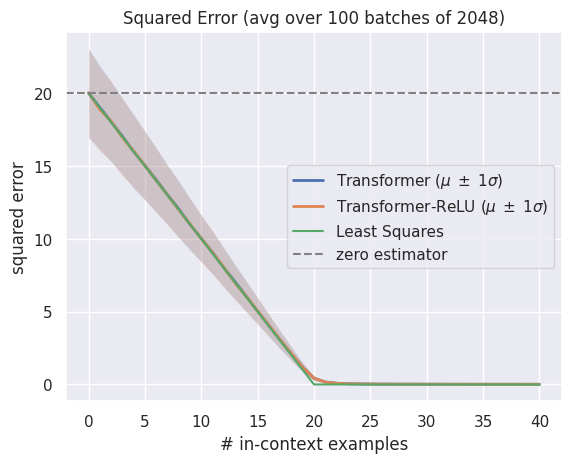

In [43]:
plt.title(f"Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])

plot_model_errs(errs, baseline=naives[task], optimal=oracle)

### Doubling Inputs

In [44]:
BATCH_SIZE = 2048
RUNS = 100
double = scale(2)
    
errs = { 
    row["model"] : get_err_from_run(
        row["run_path"], 
        mutate_xs=double, mutate_bs=bs(BATCH_SIZE),
        runs=RUNS
    ).cpu()
    for _, row in models.iterrows() 
}

Running batches: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


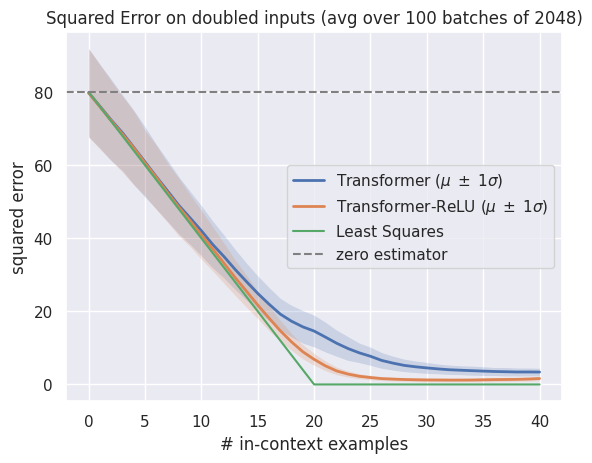

In [52]:
plt.title(f"Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

### Halving Inputs

In [55]:
BATCH_SIZE = 2048
RUNS = 100
halve = scale(0.5)

errs = { 
    row["model"] : get_err_from_run(
        row["run_path"], 
        mutate_xs=halve, mutate_bs=bs(BATCH_SIZE),
        runs=RUNS
    ).cpu()
    for _, row in models.iterrows() 
}

Running batches: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


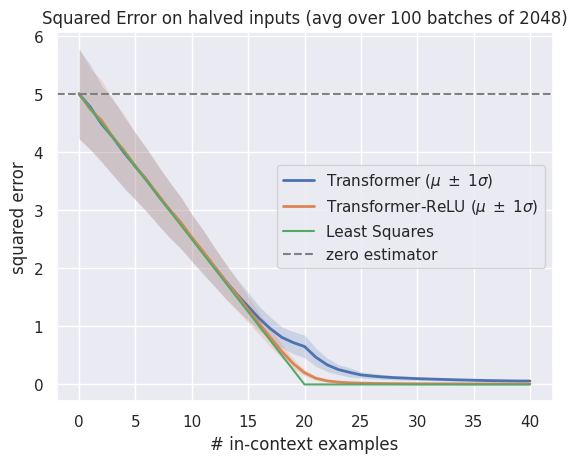

In [56]:
plt.title(f"Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

### Varying scaling factor

In [10]:
def get_scaling_errs(scales, bsize=256, runs=1, ic_examples=None):
    return {
        row['model'] : print(f"Computing error for {row['model']}") or compute_scaling_err(row['run_path'], mutate_bs=bs(bsize), scales=scales, runs=runs, ic_examples=ic_examples).mean(axis=1)
        for _, row in models.iterrows()
    }

In [6]:
def plot_scaling_errs(errs, ic_example_counts, normalize_errs=True, max_y=50):
    fig, ax = plt.subplots(1, len(ic_example_counts), sharey='all')
    fig.set_size_inches(20, 5)
    for i, ic_examples in enumerate(ic_example_counts):
        for model, err in errs.items():
            ys = err[:, ic_examples].cpu() / (scales ** 2) if normalize_errs else err[:, ic_examples]
            ax[i].plot(scales, ys, label=model)

        ax[i].set_title(f"Error with {ic_examples} examples")
        ax[i].set_xscale('log')
        ax[i].set_xlabel("Scaling factor")
        ax[i].set_ylim(0, max_y)

        naive = naives[task]
        if task in optimals.keys():
            optim = optimals[task]["error"][ic_examples]
        if normalize_errs: 
            ax[i].axhline(naive, ls="--", color="gray", label="zero estimator")
            if task in optimals.keys():
                ax[i].axhline(optim, ls="--", color="blue", label=optimals[task]["label"])
        else:
            ax[i].set_yscale('log')

            naive *= scales ** 2
            ax[i].plot(naive, ls="--", color="gray", label="zero estimator")
            
            if task in optimals.keys():
                optim *= scales ** 2
                ax[i].plot(optim, ls="--", color="blue", label=optimals[task]["label"])

        if i == 0:
            ax[i].set_ylabel("squared error")

        if i == 0:#len(ic_example_counts) - 1:
            ax[i].legend()

    return fig

In [ ]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
scaling_errs = get_scaling_errs(scales, bsize=2048, runs=5, ic_examples=100)

Computing error for Transformer


Scaling 0.700 batches:  40%|████      | 2/5 [00:11<00:17,  5.71s/it]

In [ ]:
import seaborn as sns
model = "Transformer-ReLU"
print(scaling_errs[model].shape)
sns.heatmap(scaling_errs[model].cpu().numpy(), yticklabels=scales, vmax=80)

In [ ]:
# max ys: 50 for linear, 7 for sparse linear, 1.1 for DT

In [ ]:
plot_scaling_errs(scaling_errs, [15, 20, 25, 30, 40, 70], max_y=7).show()

In [ ]:
plot_scaling_errs(scaling_errs, [18, 19, 20, 21, 22]).show()

In [43]:
scales = 10 ** np.arange(-0.8, -0.5, 0.01)
scaling_errs = get_scaling_errs(scales, bsize=2048)

100%|██████████| 31/31 [01:30<00:00,  2.93s/it]


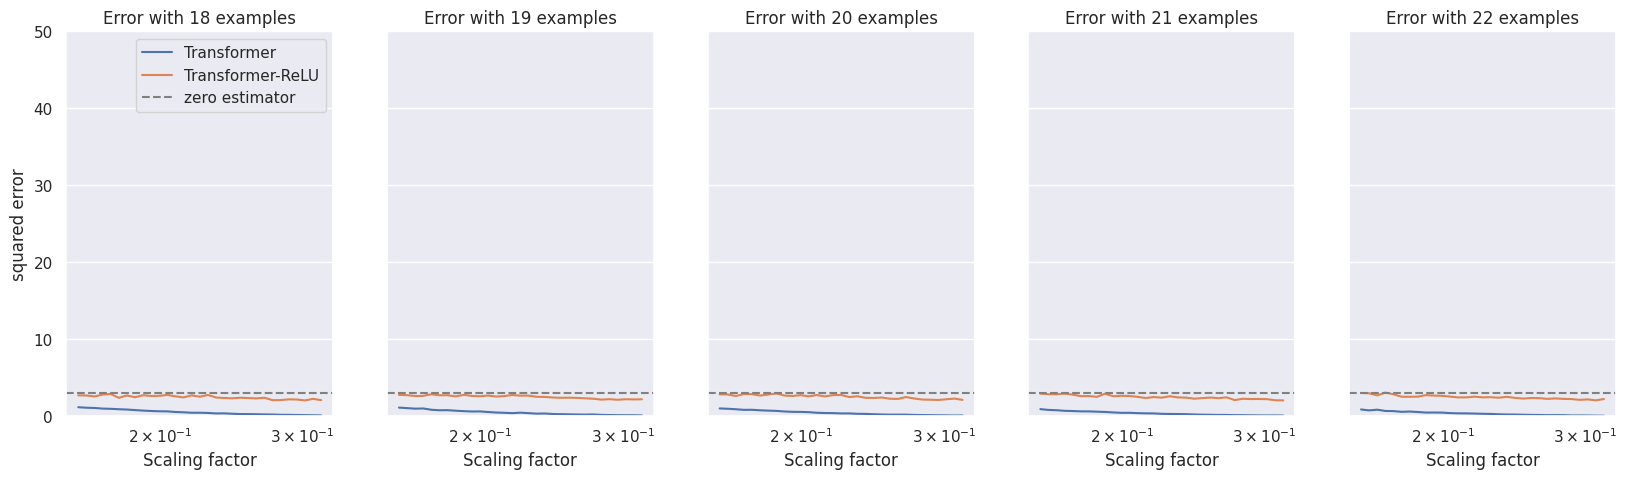

In [44]:
plot_scaling_errs(scaling_errs, [18, 19, 20, 21, 22]).show()

### Inference time

In [17]:
BATCHES = [32, 64, 128, 256, 512, 1024, 2048, 4096]
RUNS = 15

run_data = {
    row["model"] : {
        "path" : row["run_path"],
        "errs" : [], "times" : []
    } for _, row in models.iterrows()
}

for batch in BATCHES:
    print(f"Running batch size of {batch} ... ", end='')
    for model_type in run_data.keys():
        err, time = get_timed_err_from_run(run_data[model_type]["path"], mutate_bs=(lambda bs: batch), runs=RUNS)
        
        run_data[model_type]['errs'].append(err.cpu())
        run_data[model_type]['times'].append(time)

for model_type in run_data.keys():
    run_data[model_type]['errs'] = torch.stack(run_data[model_type]['errs']).cpu()

Running batch size of 32 ... 

 80%|████████  | 12/15 [00:11<00:02,  1.07it/s]


KeyboardInterrupt: 

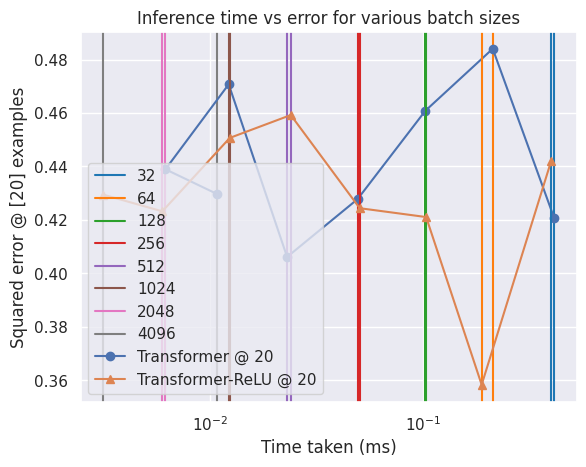

In [5]:
IC_EXAMPLES = [20]
colors=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",  "black", "red"]
markers = ["o", "^", "." , "s" , "P" , "v" , "1", "3", "*", "x", "d", "X", "8"]

for i, (marker, model_type) in enumerate(zip(markers, run_data.keys())):
    x = np.array(run_data[model_type]["times"]).mean(axis=1)  * 1e3
    y = run_data[model_type]["errs"][:, IC_EXAMPLES]
    
    for batch_time, ic, color in zip(x, BATCHES, colors):
        if i == 0:
            plt.axvline(batch_time, color=color, label=ic)
        else:
            plt.axvline(batch_time, color=color)

    for ic, errs in zip(IC_EXAMPLES, y.T):
        plt.plot(x, errs.cpu().numpy(), marker=marker, label=f"{model_type} @ {ic}")
    
plt.xscale('log')
plt.title(f"Inference time vs error for various batch sizes")
plt.xlabel("Time taken (ms)")
plt.ylabel(f"Squared error @ {IC_EXAMPLES} examples")
plt.legend()

In [18]:
RUNS = 10
TIMING_BATCH_SIZE = 2048

fixed_batch_size = lambda bs: TIMING_BATCH_SIZE

# relu_abs_loss, time_relu = get_timed_err_from_run(run_path, mutate_bs=fixed_batch_size, runs=RUNS)
# vanil_abs_loss, time_vanil = get_timed_err_from_run("../models/linear_regression/pretrained", mutate_bs=fixed_batch_size, runs=RUNS)

d = {}
for _, row in models.iterrows():
    err, time = get_timed_err_from_run(row["run_path"], mutate_bs=bs(TIMING_BATCH_SIZE), runs=RUNS)
    d[row["model"]] = {
        "errs" : err,
        "times": time
    }

with open("losses_and_times.pkl", 'wb') as f:
    pickle.dump(d, f)

100%|██████████| 10/10 [00:36<00:00,  3.60s/it]


In [ ]:
with open("losses_and_times.pkl", "rb") as f:
    d = pickle.load(f)

In [24]:
def format_times(times, title):
    print(title, [t * 1e3 for t in times], f"(mean: {np.mean(times)*1e3} +- {np.std(times)*1e3})")
format_times(d["Transformer-ReLU"]["times"], "ReLU Times :")
format_times(d["Transformer"]["times"], "Vanil Times:")

ReLU Times : [0.0059171201201024815, 0.01014905566876223, 0.005753846188838452, 0.005666858882591441, 0.005847670415448647, 0.00561401757437352, 0.005594105466855126, 0.005105721676557096, 0.005920595704367315, 0.006121378419265966] (mean: 0.006169037011716227 +- 0.0013514836364679058)
Vanil Times: [0.014694084477184788, 0.006035310057939114, 0.005023430659889527, 0.005679170897110453, 0.005336700681368711, 0.005440007818435788, 0.005300878420655408, 0.006403611820360311, 0.005302148927910366, 0.005275311529828741] (mean: 0.006449065529068321 +- 0.002775712024027586)
